In [2]:
"""Import libraries"""
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
from matplotlib import animation

from contextlib import closing
from io import StringIO
from os import path
from typing import Optional


from gym import Env, logger, spaces, utils
from gym.envs.toy_text.utils import categorical_sample
from gym.error import DependencyNotInstalled



In [3]:

MAP = [
    "+-----------+",
    "| : | : : : |",
    "|A: | :B: : |",
    "| :R: : : |C|",
    "| : : : : :R|",
    "|D| : : : : |",
    "| | : : : |E|",
    "+-----------+",
]
WINDOW_SIZE = (526,350)

class TaxiEnv(Env):
   

    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None):
        self.desc = np.asarray(MAP, dtype="c")
        self.locs = locs = [(1, 0), (1, 3), (2, 5), (4, 0), (5, 5)] # A, B, C, D, E
        self.locs_colors = [(0, 255, 255), (0, 255, 0), (225, 225, 225), (0, 0, 255), (255, 0, 255)]   
        self.restricted = {(2, 1), (3, 5)} # R
                        
        num_states = 1080 
        num_rows = 6
        num_columns = 6
        max_row = num_rows - 1
        max_col = num_columns - 1
        self.initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        self.P = {
            state: {action: [] for action in range(num_actions)}
            for state in range(num_states)
        }
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        
                         # Only allow initial taxi positions that are not restricted and not in the passenger location
                        if (
                            pass_idx < (len(locs)) 
                            and pass_idx != dest_idx
                            and (row, col) not in self.restricted
                        ):
                            self.initial_state_distrib[state] += 1
                             
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = (
                                -1
                            )  # default reward when there is no pickup/dropoff
                            terminated = False
                            taxi_loc = (row, col)
                            
                            # MOVE SOUTH (Action 0)
                            if action == 0:
                                new_row = min(row + 1, max_row)
                                if (new_row, col) in self.restricted:
                                    new_row = row 
                                    
                            # MOVE NORTH (Action 1)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                                if (new_row, col) in self.restricted:
                                    new_row = row 
                                    
                            # MOVE EAST (Action 2)
                            if action == 2 and self.desc[1 + row, 2 * col + 2] == b":":
                                new_col = min(col + 1, max_col)
                                if (new_row, new_col) in self.restricted:  # Check if new position is restricted
                                    new_col = col 
                            
                            # MOVE WEST (Action 3)
                            elif action == 3 and self.desc[1 + row, 2 * col] == b":":
                                new_col = max(col - 1, 0)
                                if (new_row, new_col) in self.restricted:   # Check if new position is restricted
                                    new_col = col 
                                
                            # PICKUP (Action 4)
                            elif action == 4:  
                                # Check if passenger is at a pickup location and taxi is there
                                if pass_idx < 5 and taxi_loc == locs[pass_idx]:
                                    new_pass_idx = 5  # Move to "Inside Taxi" state
                                else:
                                    reward = (-10)
                                    
                            # DROPOFF (Action 5)
                            elif action == 5: 
                                # Check if passenger is inside taxi (idx == 5) and at destination
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 5:
                                    new_pass_idx = dest_idx # Successfully dropped off
                                    terminated = True
                                    reward = 20
                                elif (taxi_loc in locs) and pass_idx == 5:
                                    new_pass_idx = locs.index(taxi_loc) # Dropped at wrong location
                                else: 
                                    reward = (-10)
                                    
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx
                            )
                            self.P[state][action].append(
                                (1.0, new_state, reward, terminated)
                            )
        self.initial_state_distrib /= self.initial_state_distrib.sum()
        self.action_space = spaces.Discrete(num_actions)
        self.observation_space = spaces.Discrete(num_states)

        self.render_mode = render_mode

        # pygame utils
        self.window = None
        self.clock = None
        self.cell_size = (
            WINDOW_SIZE[0] / self.desc.shape[1],
            WINDOW_SIZE[1] / self.desc.shape[0],
        )
        self.taxi_imgs = None
        self.taxi_orientation = 0
        self.passenger_img = None
        self.destination_img = None
        self.median_horiz = None
        self.median_vert = None
        self.background_img = None

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (6) 6, 6, 5
        i = taxi_row   
        i *= 6         
        i += taxi_col  
        i *= 6        
        i += pass_loc  
        i *= 5        
        i += dest_idx  
        return i

    def decode(self, i):
        out = []
        out.append(i % 5)  # 5 destinations
        i = i // 5
        out.append(i % 6)  # 6 passenger locations
        i = i // 6
        out.append(i % 6)  # 6 columns
        i = i // 6
        out.append(i)      # 6 rows
        assert 0 <= i < 6
        return reversed(out)

    # Compute the action mask for the action space using the state information
    def action_mask(self, state: int):
            
        max_row = 5 
        max_col = 5 

        mask = np.zeros(6, dtype=np.int8)
        taxi_row, taxi_col, pass_loc, dest_idx = self.decode(state)
        
        # south
        if taxi_row < max_row and (taxi_row + 1, taxi_col) not in self.restricted:
            mask[0] = 1
        # north
        if taxi_row > 0 and (taxi_row - 1, taxi_col) not in self.restricted:
            mask[1] = 1
        # east (respect internal walls in map and restricted areas)
        if (
            taxi_col < max_col
            and self.desc[taxi_row + 1, 2 * taxi_col + 2] == b":"
            and (taxi_row, taxi_col + 1) not in self.restricted
        ):
            mask[2] = 1
        # west (respect internal walls in map and restricted areas)
        if (
            taxi_col > 0
            and self.desc[taxi_row + 1, 2 * taxi_col] == b":"
            and (taxi_row, taxi_col - 1) not in self.restricted
        ):
            mask[3] = 1
        # pickup
        if pass_loc < len(self.locs) and (taxi_row, taxi_col) == self.locs[pass_loc]:
            mask[4] = 1
        # dropoff
        if pass_loc == len(self.locs) and (
            (taxi_row, taxi_col) == self.locs[dest_idx]
            or (taxi_row, taxi_col) in self.locs
        ):
            mask[5] = 1
        return mask
    
    # Take a step in the environment
    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.render_mode == "human":
            self.render()
        return (int(s), r, t, False, {"prob": p, "action_mask": self.action_mask(s)})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None
        self.taxi_orientation = 0

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1.0, "action_mask": self.action_mask(self.s)}
    # Render the environment
    def render(self):
        if self.render_mode is None:
            logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
        if self.render_mode == "ansi":
            return self._render_text()
        else:  # self.render_mode in {"human", "rgb_array"}:
            return self._render_gui(self.render_mode)

    # Render the environment as a pygame window
    def _render_gui(self, mode):
        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled("pygame is not installed")

        if self.window is None:
            pygame.init()
            pygame.display.set_caption("Taxi")
            if mode == "human":
                self.window = pygame.display.set_mode(WINDOW_SIZE)
            elif mode == "rgb_array":
                self.window = pygame.Surface(WINDOW_SIZE)

        if self.clock is None:
            self.clock = pygame.time.Clock()
            
        # Load images 
        if self.taxi_imgs is None:
            file_names = [
                path.join(".", "img/cab_front.png"),
                path.join(".", "img/cab_rear.png"),
                path.join(".", "img/cab_right.png"),
                path.join(".", "img/cab_left.png"),
            ]
            self.taxi_imgs = [pygame.transform.scale(pygame.image.load(f), self.cell_size) for f in file_names]
        if self.passenger_img is None:
            self.passenger_img = pygame.transform.scale(pygame.image.load(path.join(".", "img/passenger.png")), self.cell_size)
        if self.destination_img is None:
            img = pygame.image.load(path.join(".", "img/hotel.png"))
            self.destination_img = pygame.transform.scale(img, self.cell_size)
            self.destination_img.set_alpha(170)
        if self.median_horiz is None:
            names = ["img/gridworld_median_left.png", "img/gridworld_median_horiz.png", "img/gridworld_median_right.png"]
            self.median_horiz = [pygame.transform.scale(pygame.image.load(path.join(".", f)), self.cell_size) for f in names]
        if self.median_vert is None:
            names = ["img/gridworld_median_top.png", "img/gridworld_median_vert.png", "img/gridworld_median_bottom.png"]
            self.median_vert = [pygame.transform.scale(pygame.image.load(path.join(".", f)), self.cell_size) for f in names]
        if self.background_img is None:
            self.background_img = pygame.transform.scale(pygame.image.load(path.join(".", "img/taxi_background.png")), self.cell_size)

        # --- DRAWING --- 
        desc = self.desc
        for y in range(0, desc.shape[0]):
            for x in range(0, desc.shape[1]):
                cell = (x * self.cell_size[0], y * self.cell_size[1])
                self.window.blit(self.background_img, cell)
                # Draw walls 
                if desc[y][x] == b"|" and (y == 0 or desc[y - 1][x] != b"|"):
                    self.window.blit(self.median_vert[0], cell)
                elif desc[y][x] == b"|" and (y == desc.shape[0] - 1 or desc[y + 1][x] != b"|"):
                    self.window.blit(self.median_vert[2], cell)
                elif desc[y][x] == b"|":
                    self.window.blit(self.median_vert[1], cell)
                elif desc[y][x] == b"-" and (x == 0 or desc[y][x - 1] != b"-"):
                    self.window.blit(self.median_horiz[0], cell)
                elif desc[y][x] == b"-" and (x == desc.shape[1] - 1 or desc[y][x + 1] != b"-"):
                    self.window.blit(self.median_horiz[2], cell)
                elif desc[y][x] == b"-":
                    self.window.blit(self.median_horiz[1], cell)

        # Draw Locations 
        for cell, color in zip(self.locs, self.locs_colors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(128)
            color_cell.fill(color)
            loc = self.get_surf_loc(cell)
            self.window.blit(color_cell, (loc[0], loc[1] + 10))

        # Draw Restricted Areas (Red)
        for cell in self.restricted:
            restricted_cell = pygame.Surface(self.cell_size)
            restricted_cell.set_alpha(128)
            restricted_cell.fill((255, 0, 0))
            loc = self.get_surf_loc(cell)
            self.window.blit(restricted_cell, (loc[0], loc[1] + 10))

        # Draw Entities
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)
        # Draw passenger (if not in taxi)
        if pass_idx < 5:
            self.window.blit(self.passenger_img, self.get_surf_loc(self.locs[pass_idx]))

        if self.lastaction in [0, 1, 2, 3]:
            self.taxi_orientation = self.lastaction
        
        dest_loc = self.get_surf_loc(self.locs[dest_idx])
        taxi_location = self.get_surf_loc((taxi_row, taxi_col))

        if dest_loc[1] <= taxi_location[1]:
            self.window.blit(self.destination_img, (dest_loc[0], dest_loc[1] - self.cell_size[1] // 2))
            self.window.blit(self.taxi_imgs[self.taxi_orientation], taxi_location)
        else:
            self.window.blit(self.taxi_imgs[self.taxi_orientation], taxi_location)
            self.window.blit(self.destination_img, (dest_loc[0], dest_loc[1] - self.cell_size[1] // 2))

        if mode == "human":
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        elif mode == "rgb_array":
            return np.transpose(np.array(pygame.surfarray.pixels3d(self.window)), axes=(1, 0, 2))

    # Get the location of a cell in the pygame window
    def get_surf_loc(self, map_loc):  
        return (map_loc[1] * 2 + 1) * self.cell_size[0], (
            map_loc[0] + 1
        ) * self.cell_size[1]

    # Render the environment as a text based representation
    def _render_text(self): 
        desc = self.desc.copy().tolist()
        outfile = StringIO()

        out = [[c.decode("utf-8") for c in line] for line in desc]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x):
            return "_" if x == " " else x

        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], "yellow", highlight=True
            )
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(
                out[1 + pi][2 * pj + 1], "blue", bold=True
            )
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), "green", highlight=True
            )

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], "magenta")
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write(
                f"  ({['South', 'North', 'East', 'West', 'Pickup', 'Dropoff'][self.lastaction]})\n"
            )
        else:
            outfile.write("\n")

        with closing(outfile):
            return outfile.getvalue()

    def close(self):
        if self.window is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()


# Taxi rider from https://franuka.itch.io/rpg-asset-pack
# All other assets by Mel Tillery http://www.cyaneus.com/

In [4]:
# Run animation
def run_animation(experience_buffer):
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        # Print console output
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")

        # Pauze animation
        sleep(time_lag)

In [5]:
# Store episode as gif animation
def store_episode_as_gif(experience_buffer, path='./', filename='animation2.gif'):
    fps = 5   # Set framew per seconds
    dpi = 30  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(path + filename, writer='imagemagick', fps=fps)

## Environment initialization

State space: Discrete(1080)
Action space: Discrete(6)
State: 21
Action: 2
Action mask: [1 0 1 0 0 0]
Reward: -1


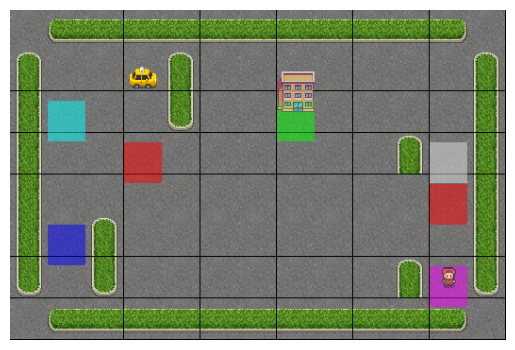

In [11]:
"""Initialize and validate the environment"""
env = TaxiEnv(render_mode="rgb_array")
state, _ = env.reset()

# Print dimensions of state and action space
print("State space: {}".format(env.observation_space))
print("Action space: {}".format(env.action_space))

# Sample random action
action = env.action_space.sample(env.action_mask(state))
next_state, reward, done, _, _ = env.step(action)

# Print output
print("State: {}".format(state))
print("Action: {}".format(action))
print("Action mask: {}".format(env.action_mask(state)))
print("Reward: {}".format(reward))

# Render and plot an environment frame
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

# Simulation with random agent

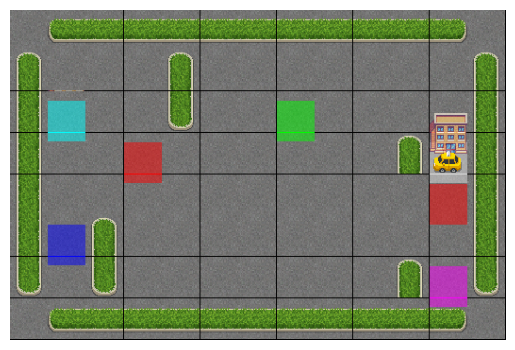

Episode: 1/1
Epoch: 5755/5755
State: 522
Action: 5
Reward: -22610
# epochs: 5756
# failed drop-offs: 1875


In [7]:
"""Simulation with random agent"""
epoch = 0
num_failed_dropoffs = 0
experience_buffer = []
cum_reward = 0

done = False

state, _ = env.reset()

while not done:
    # Sample random action
    action = env.action_space.sample()
    #action = env.action_space.sample(env.action_mask(state))

    state, reward, done, _, _ = env.step(action)
    cum_reward += reward

    # Store experience in dictionary
    experience_buffer.append({
        "frame": env.render(),
        "episode": 1,
        "epoch": epoch,
        "state": state,
        "action": action,
        "reward": cum_reward,
        }
    )

    if reward == -10:
        num_failed_dropoffs += 1

    epoch += 1

# Run animation and print console output
run_animation(experience_buffer)

print("# epochs: {}".format(epoch))
print("# failed drop-offs: {}".format(num_failed_dropoffs))

## Training the agent

Episode #: 10000
Best cumulative reward: 16.0 at Episode 488


===Training completed.===

CSV files saved.


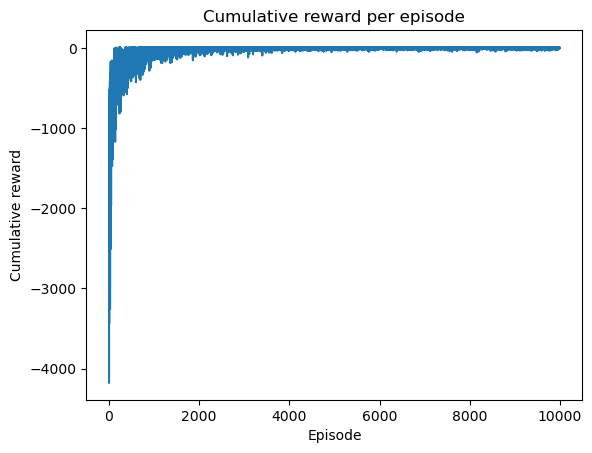

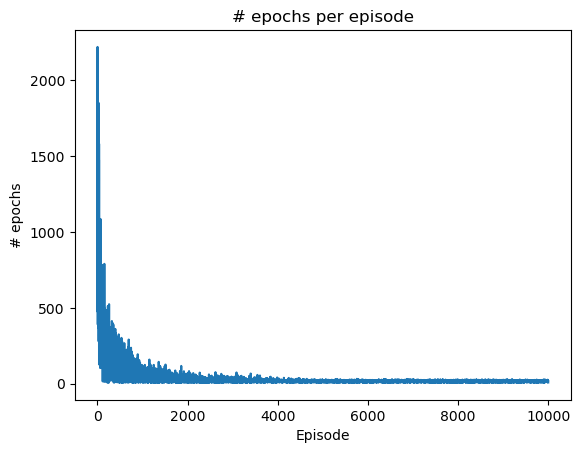

CPU times: total: 17 s
Wall time: 17.1 s


In [8]:
%%time 

"""Training the agent"""
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 1.0  # Discount rate
epsilon = 0.1  # Exploration rate
num_episodes = 10000  # Number of episodes

best_episode_idx = -1
best_cum_reward = -float('inf')

# Output for plots
cum_rewards = np.zeros([num_episodes])
total_epochs = np.zeros([num_episodes])

for episode in range(1, num_episodes+1):
    # Reset environment
    state, info = env.reset()
    epoch = 0 
    num_failed_dropoffs = 0
    done = False
    cum_reward = 0

    while not done:
        
        if random.uniform(0, 1) < epsilon:
            "Basic exploration [~0.47m]"
            action = env.action_space.sample() # Sample random action (exploration)
            
            "Exploration with action mask [~1.52m]"
          # action = env.action_space.sample(env.action_mask(state)) "Exploration with action mask"
        else:      
            "Exploitation with action mask [~1m52s]"
           # action_mask = np.where(info["action_mask"]==1,0,1) # invert
           # masked_q_values = np.ma.array(q_table[state], mask=action_mask, dtype=np.float32)
           # action = np.ma.argmax(masked_q_values, axis=0)

            "Exploitation with random tie breaker [~1m19s]"
          #  action = np.random.choice(np.flatnonzero(q_table[state] == q_table[state].max()))
            
            "Basic exploitation [~47s]"
            action = np.argmax(q_table[state]) # Select best known action (exploitation)
 
        next_state, reward, done, _ , info = env.step(action) 

        cum_reward += reward
        
        old_q_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)
        
        q_table[state, action] = new_q_value
        
        if reward == -10:
            num_failed_dropoffs += 1

        state = next_state
        epoch += 1
        
        total_epochs[episode-1] = epoch
        cum_rewards[episode-1] = cum_reward

    if episode % 100 == 0: # Print progress
        clear_output(wait=True)
        print(f"Episode #: {episode}")
    # Check for the best model each 300 episodes
    if episode%300 == 0 or episode == num_episodes: 
        for i in range(episode-300, episode):
            if cum_rewards[i] > best_cum_reward:
                best_cum_reward = cum_rewards[i]
                best_episode_idx = i
                print(f"   --> New best model found at Episode {i}!")
                print(f"      --> Cumulative reward: {best_cum_reward}")                
   
                
print(f"Best cumulative reward: {best_cum_reward} at Episode {best_episode_idx+1}")
print("\n")
print("===Training completed.===\n")

# Save Q-table to CSV
np.savetxt('taxi_q_table.csv', q_table, delimiter=',')
print("CSV files saved.")

# Plot reward convergence
plt.title("Cumulative reward per episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.plot(cum_rewards)
plt.show()

# Plot epoch convergence
plt.title("# epochs per episode")
plt.xlabel("Episode")
plt.ylabel("# epochs")
plt.plot(total_epochs)
plt.show()

## Performance test

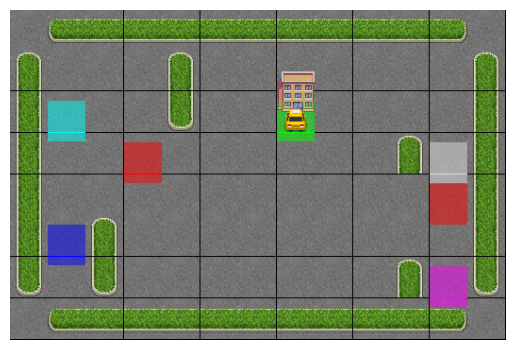

Episode: 1/1
Epoch: 14/14
State: 276
Action: 5
Reward: 7


Test results after 1 episodes:
Mean # epochs per episode: 15.0
Mean # failed drop-offs per episode: 0.0


In [16]:
"""Test policy performance after training"""

# use saved Q-table
q_table = np.loadtxt('taxi_q_table.csv', delimiter=',') 

num_epochs = 0
total_failed_deliveries = 0
num_episodes = 1
experience_buffer = []
store_gif = True

for episode in range(1, num_episodes+1):
    # Initialize experience buffer
    env = TaxiEnv(render_mode="rgb_array")
    my_env = env.reset()
    state = my_env[0]
    epoch = 1 
    num_failed_deliveries = 0
    cum_reward = 0
    done = False

    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, _, _ = env.step(action)
        cum_reward += reward

        if reward == -10:
            num_failed_deliveries += 1

        # Store rendered frame in animation dictionary
        experience_buffer.append({
            'frame': env.render(),
            'episode': episode,
            'epoch': epoch,
            'state': state,
            'action': action,
            'reward': cum_reward
            }
        )

        epoch += 1

    total_failed_deliveries += num_failed_deliveries
    num_epochs += epoch

    if store_gif:
        store_episode_as_gif(experience_buffer)

# Run animation and print output
run_animation(experience_buffer)

# Print final results
print("\n") 
print(f"Test results after {num_episodes} episodes:")
print(f"Mean # epochs per episode: {num_epochs / num_episodes}")
print(f"Mean # failed drop-offs per episode: {total_failed_deliveries / num_episodes}")